In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
combined_data = pd.read_csv('data/combined_data/cleaned_data.csv')

In [3]:
combined_data.head()

,T,TM,Tm,H,PP,VV,V,VM,PM_2_5
0,24.2,32.0,21.9,71.0,2.54,6.9,0.2,1.9,54.0
1,24.9,29.6,21.6,71.0,0.25,6.9,1.9,3.5,93.0
2,24.9,31.2,22.2,77.0,0.00,6.3,3.1,7.6,64.0
3,24.8,32.0,20.2,78.0,0.00,6.3,4.6,11.1,72.0
4,26.3,33.0,19.1,76.0,39.12,6.9,5.2,7.6,74.0


In [8]:
X = combined_data.iloc[:, :-1]
y = combined_data.iloc[:, -1]

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

## XGBOOST REGRESSOR

In [7]:
!pip install xgboost
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 166.7 MB 15 kB/s 
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [9]:
f'Coefficient of determination R^2 on train set {xgb.score(X_train, y_train)}'
# must be close to 1, 1 is perfect fit

'Coefficient of determination R^2 on train set 0.9986682779955492'

In [10]:
f'Coefficient of determination R^2 on test set {xgb.score(X_test, y_test)}'

'Coefficient of determination R^2 on test set 0.18973909745024897'

In [11]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(xgb, X, y, cv = 3)

In [12]:
score.mean()

-0.030629011608158858

In [13]:
pred = xgb.predict(X_test)

/home/fish/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PM_2_5', ylabel='Density'>

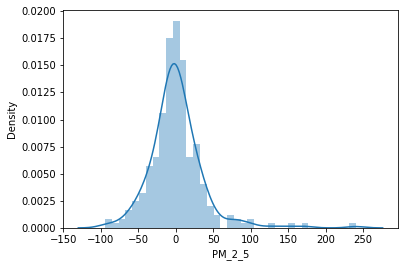

In [14]:
sns.distplot(y_test - pred)

#### HYPERPARAMETER TUNING

In [15]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=1200, num=12)]
learning_rate = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
max_depth = [int(x) for x in np.linspace(5, 30, num=6)]
subsample = [0.7, 0.6, 0.8]
min_child_weight = list(range(3, 8))
objective = ['reg:squarederror']
params = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'max_depth': max_depth,
    'subsample': subsample,
    'min_child_weight': min_child_weight,
    'objective': objective
}

In [16]:
from sklearn.model_selection import RandomizedSearchCV
search = RandomizedSearchCV(xgb, params, scoring='neg_mean_squared_error', 
                            cv=5, n_iter=100, random_state=43, n_jobs=-1, verbose=True)
search.fit(X,y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [19]:
search.best_params_

{'subsample': 0.8,
 'objective': 'reg:squarederror',
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 20,
 'learning_rate': 0.05}

In [20]:
search.best_score_

-5025.759472697369

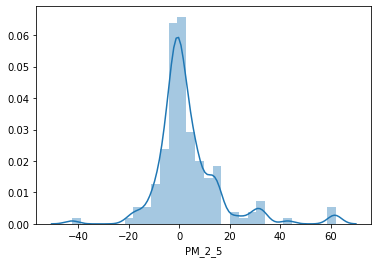

In [21]:
pred = search.predict(X_test)
sns.distplot(y_test-pred)

In [22]:
from sklearn import metrics
print(f"Mean Abs Error: {metrics.mean_absolute_error(y_test, pred)}")
print(f"Mean Sq Error: {metrics.mean_squared_error(y_test, pred)}")
print(f"Root Mean Error: {np.sqrt(metrics.mean_squared_error(y_test, pred))}")

Mean Abs Error: 8.277064511406477
Mean Sq Error: 192.08441507308692
Root Mean Error: 13.859452192387941


In [24]:
search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=20, min_child_weight=3, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

In [25]:
import pickle
pickle.dump(search, open('xgb.pkl', 'wb'))